In [1]:
# Cell 1: Imports & Setup
import os
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
# Cell 2: Define dataset & working directory
WORK_DIR = Path("E:/Nibm/Degree/4th_Year/CV/Individual_CW/CV_CW/CV_CW")  # adjust path for your PC
ORIG_DIR = WORK_DIR / "PlantVillage"   # The original dataset folder (class subfolders inside)

print("Dataset root:", ORIG_DIR)


Dataset root: E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\PlantVillage


In [3]:
# Cell 3: Create train/val/test split (70/15/15)
SPLIT_DIR = WORK_DIR / "split"
train_dir = SPLIT_DIR / "train"
val_dir = SPLIT_DIR / "val"
test_dir = SPLIT_DIR / "test"

# Reset split folder
if SPLIT_DIR.exists():
    shutil.rmtree(SPLIT_DIR)
for p in [train_dir, val_dir, test_dir]:
    p.mkdir(parents=True, exist_ok=True)

split_ratios = (0.7, 0.15, 0.15)

for class_dir in ORIG_DIR.iterdir():
    if not class_dir.is_dir():
        continue
    imgs = list(class_dir.glob('*'))
    random.shuffle(imgs)
    n = len(imgs)
    n_train = int(n * split_ratios[0])
    n_val = int(n * split_ratios[1])
    train_files = imgs[:n_train]
    val_files = imgs[n_train:n_train+n_val]
    test_files = imgs[n_train+n_val:]

    (train_dir / class_dir.name).mkdir(parents=True, exist_ok=True)
    (val_dir / class_dir.name).mkdir(parents=True, exist_ok=True)
    (test_dir / class_dir.name).mkdir(parents=True, exist_ok=True)

    for f in train_files:
        shutil.copy(f, train_dir / class_dir.name / f.name)
    for f in val_files:
        shutil.copy(f, val_dir / class_dir.name / f.name)
    for f in test_files:
        shutil.copy(f, test_dir / class_dir.name / f.name)

print("Split completed. Counts:")
for p in [train_dir, val_dir, test_dir]:
    count = sum(len(list(c.glob('*'))) for c in p.iterdir())
    print(p.name, "-", count, "images")


Split completed. Counts:
train - 14441 images
val - 3089 images
test - 3109 images


In [4]:
# Cell 4: Data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', seed=SEED
)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

class_indices = train_flow.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
print("Classes:", class_indices)


Found 14440 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Found 3109 images belonging to 15 classes.
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [5]:
# Cell 5: Compute class weights
labels = train_flow.classes
classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights = {int(i): float(w) for i,w in enumerate(class_weights)}
print("Class weights calculated for", len(class_weights), "classes")


Class weights calculated for 15 classes


In [6]:
# Cell 6: Build Simple CNN
def build_simple_cnn(input_shape=(224,224,3), n_classes=None):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    return models.Model(inp, out)

num_classes = len(class_indices)
cnn_model = build_simple_cnn(n_classes=num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,127 (508.31 KB)

 Trainable params: 130,127 (508.31 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cell 7: Build MobileNetV2
def build_mobilenetv2(input_shape=(224,224,3), n_classes=None, train_base=False):
    base = applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = train_base
    inp = layers.Input(shape=input_shape)
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    return models.Model(inp, out)

mobilenet_model = build_mobilenetv2(n_classes=num_classes, train_base=False)
mobilenet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Cell 8: Callbacks
checkpoint_dir = WORK_DIR / "checkpoints"
checkpoint_dir.mkdir(exist_ok=True)
cb_list = [
    callbacks.ModelCheckpoint(str(checkpoint_dir / "best_model.h5"), monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]


In [9]:
# Cell 9: Train CNN
EPOCHS = 15
history_cnn = cnn_model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    class_weight=class_weights,
    callbacks=cb_list
)
cnn_model.save(WORK_DIR / "cnn_model.h5")


e:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.1289 - loss: 2.6276
Epoch 1: val_accuracy improved from None to 0.17999, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 265s 583ms/step - accuracy: 0.2071 - loss: 2.4406 - val_accuracy: 0.1800 - val_loss: 3.5567 - learning_rate: 0.0010
Epoch 2/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3470 - loss: 1.9898
Epoch 2: val_accuracy improved from 0.17999 to 0.43639, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.3961 - loss: 1.8038 - val_accuracy: 0.4364 - val_loss: 1.8523 - learning_rate: 0.0010
Epoch 3/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.5068 - loss: 1.4114
Epoch 3: val_accuracy did not improve from 0.43639
452/452 ━━━━━━━━━━━━━━━━━━━━ 301s 667ms/step - accuracy: 0.5285 - loss: 1.3500 - val_accuracy: 0.4027 - val_loss: 1.9314 - learning_rate: 0.0010
Epoch 4/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.5904 - loss: 1.1880
Epoch 4: val_accuracy did not improve from 0.43639
452/452 ━━━━━━━━━━━━━━━━━━━━ 293s 648ms/step - accuracy: 0.6087 - loss: 1.1318 - val_accuracy: 0.4293 - val_loss: 2.0668 - learning_rate: 0.0010
Epoch 5/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6438 - loss: 1.0375
Epoch 5: val_accuracy improved from 0.43639 to 0.57494, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.6625 - loss: 0.9819 - val_accuracy: 0.5749 - val_loss: 1.3323 - learning_rate: 0.0010
Epoch 6/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6837 - loss: 0.9149
Epoch 6: val_accuracy did not improve from 0.57494
452/452 ━━━━━━━━━━━━━━━━━━━━ 273s 603ms/step - accuracy: 0.6999 - loss: 0.8693 - val_accuracy: 0.5228 - val_loss: 1.9449 - learning_rate: 0.0010
Epoch 7/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.7176 - loss: 0.8170
Epoch 7: val_accuracy improved from 0.57494 to 0.64487, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 278s 614ms/step - accuracy: 0.7307 - loss: 0.7908 - val_accuracy: 0.6449 - val_loss: 1.1987 - learning_rate: 0.0010
Epoch 8/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7597 - loss: 0.7033
Epoch 8: val_accuracy did not improve from 0.64487
452/452 ━━━━━━━━━━━━━━━━━━━━ 317s 602ms/step - accuracy: 0.7629 - loss: 0.7007 - val_accuracy: 0.5908 - val_loss: 1.5566 - learning_rate: 0.0010
Epoch 9/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7628 - loss: 0.6929
Epoch 9: val_accuracy improved from 0.64487 to 0.65879, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 279s 617ms/step - accuracy: 0.7738 - loss: 0.6551 - val_accuracy: 0.6588 - val_loss: 1.1438 - learning_rate: 0.0010
Epoch 10/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.7884 - loss: 0.6236
Epoch 10: val_accuracy did not improve from 0.65879
452/452 ━━━━━━━━━━━━━━━━━━━━ 274s 607ms/step - accuracy: 0.7934 - loss: 0.6046 - val_accuracy: 0.5937 - val_loss: 1.2999 - learning_rate: 0.0010
Epoch 11/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7949 - loss: 0.5861
Epoch 11: val_accuracy did not improve from 0.65879
452/452 ━━━━━━━━━━━━━━━━━━━━ 274s 605ms/step - accuracy: 0.8026 - loss: 0.5670 - val_accuracy: 0.5607 - val_loss: 2.0285 - learning_rate: 0.0010
Epoch 12/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.8133 - loss: 0.5248
Epoch 12: val_accuracy did not improve from 0.65879
452/452 ━━━━━━━━━━━━━━━━━━━━ 280s 619ms/step - accuracy: 0.8171 - loss: 0.5308 - val_accuracy: 0.6267 - val_loss: 1.6299 - learning_rate: 0.00

452/452 ━━━━━━━━━━━━━━━━━━━━ 273s 604ms/step - accuracy: 0.8527 - loss: 0.4232 - val_accuracy: 0.8407 - val_loss: 0.4756 - learning_rate: 5.0000e-04
Epoch 14/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8643 - loss: 0.3971
Epoch 14: val_accuracy did not improve from 0.84073
452/452 ━━━━━━━━━━━━━━━━━━━━ 608s 1s/step - accuracy: 0.8597 - loss: 0.4059 - val_accuracy: 0.7718 - val_loss: 0.7135 - learning_rate: 5.0000e-04
Epoch 15/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8617 - loss: 0.4165
Epoch 15: val_accuracy did not improve from 0.84073
452/452 ━━━━━━━━━━━━━━━━━━━━ 269s 595ms/step - accuracy: 0.8657 - loss: 0.3939 - val_accuracy: 0.7468 - val_loss: 0.9458 - learning_rate: 5.0000e-04


In [13]:
cnn_model.save("models/model_one.keras")

In [17]:
# Cell 10: Train MobileNetV2
EPOCHS_MN = 15
history_mn = mobilenet_model.fit(
    train_flow,
    epochs=EPOCHS_MN,
    validation_data=val_flow,
    class_weight=class_weights,
    callbacks=cb_list
)
mobilenet_model.save(WORK_DIR / "mobilenetv2_model.h5")


Epoch 1/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.6936 - loss: 0.9811
Epoch 1: val_accuracy improved from None to 0.78634, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.6938 - loss: 0.9812 - val_accuracy: 0.7863 - val_loss: 0.8050 - learning_rate: 6.2500e-06
Epoch 2/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6982 - loss: 0.9419
Epoch 2: val_accuracy improved from 0.78634 to 0.79022, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/step - accuracy: 0.6925 - loss: 0.9539 - val_accuracy: 0.7902 - val_loss: 0.7871 - learning_rate: 6.2500e-06
Epoch 3/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7038 - loss: 0.9283
Epoch 3: val_accuracy improved from 0.79022 to 0.79119, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.7003 - loss: 0.9414 - val_accuracy: 0.7912 - val_loss: 0.7718 - learning_rate: 6.2500e-06
Epoch 4/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.7042 - loss: 0.9275
Epoch 4: val_accuracy improved from 0.79119 to 0.79314, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 260s 576ms/step - accuracy: 0.7043 - loss: 0.9205 - val_accuracy: 0.7931 - val_loss: 0.7545 - learning_rate: 6.2500e-06
Epoch 5/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7126 - loss: 0.9105
Epoch 5: val_accuracy improved from 0.79314 to 0.79735, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 274s 607ms/step - accuracy: 0.7154 - loss: 0.8925 - val_accuracy: 0.7973 - val_loss: 0.7378 - learning_rate: 6.2500e-06
Epoch 6/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7244 - loss: 0.8792
Epoch 6: val_accuracy improved from 0.79735 to 0.79767, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 1638s 4s/step - accuracy: 0.7195 - loss: 0.8823 - val_accuracy: 0.7977 - val_loss: 0.7254 - learning_rate: 6.2500e-06
Epoch 7/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7241 - loss: 0.8499
Epoch 7: val_accuracy did not improve from 0.79767
452/452 ━━━━━━━━━━━━━━━━━━━━ 1605s 4s/step - accuracy: 0.7231 - loss: 0.8579 - val_accuracy: 0.7967 - val_loss: 0.7178 - learning_rate: 6.2500e-06
Epoch 8/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7279 - loss: 0.8421
Epoch 8: val_accuracy improved from 0.79767 to 0.80155, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 1664s 4s/step - accuracy: 0.7269 - loss: 0.8529 - val_accuracy: 0.8016 - val_loss: 0.7057 - learning_rate: 6.2500e-06
Epoch 9/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7273 - loss: 0.8341
Epoch 9: val_accuracy improved from 0.80155 to 0.80220, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 1821s 4s/step - accuracy: 0.7294 - loss: 0.8309 - val_accuracy: 0.8022 - val_loss: 0.6924 - learning_rate: 6.2500e-06
Epoch 10/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.7421 - loss: 0.8228
Epoch 10: val_accuracy did not improve from 0.80220
452/452 ━━━━━━━━━━━━━━━━━━━━ 397s 870ms/step - accuracy: 0.7379 - loss: 0.8189 - val_accuracy: 0.8022 - val_loss: 0.6844 - learning_rate: 6.2500e-06
Epoch 11/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7389 - loss: 0.8064
Epoch 11: val_accuracy improved from 0.80220 to 0.80673, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 288s 638ms/step - accuracy: 0.7408 - loss: 0.8101 - val_accuracy: 0.8067 - val_loss: 0.6704 - learning_rate: 6.2500e-06
Epoch 12/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7408 - loss: 0.8033
Epoch 12: val_accuracy improved from 0.80673 to 0.80932, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.7392 - loss: 0.8029 - val_accuracy: 0.8093 - val_loss: 0.6604 - learning_rate: 6.2500e-06
Epoch 13/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7413 - loss: 0.7937
Epoch 13: val_accuracy improved from 0.80932 to 0.80965, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 447s 989ms/step - accuracy: 0.7449 - loss: 0.7896 - val_accuracy: 0.8096 - val_loss: 0.6523 - learning_rate: 6.2500e-06
Epoch 14/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7552 - loss: 0.7688
Epoch 14: val_accuracy improved from 0.80965 to 0.81062, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 1344s 3s/step - accuracy: 0.7546 - loss: 0.7664 - val_accuracy: 0.8106 - val_loss: 0.6502 - learning_rate: 6.2500e-06
Epoch 15/15
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7678 - loss: 0.7619
Epoch 15: val_accuracy improved from 0.81062 to 0.81191, saving model to E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW\checkpoints\best_model.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 340s 753ms/step - accuracy: 0.7601 - loss: 0.7587 - val_accuracy: 0.8119 - val_loss: 0.6382 - learning_rate: 6.2500e-06


In [19]:
mobilenet_model.save("models/model_two.keras")

In [20]:
# Cell 11: Evaluate Models with explicit metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, generator, model_name="Model"):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    preds = model.predict(generator, steps=steps, verbose=1)
    y_true = generator.classes
    y_pred = np.argmax(preds, axis=1)

    target_names = [inv_class_indices[i] for i in range(num_classes)]

    # Classification report
    print(f"\n=== {model_name} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    # Explicit metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n=== {model_name} Overall Performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    return cm, (acc, prec, rec, f1)

print("Evaluating CNN:")
cm_cnn, metrics_cnn = evaluate_model(cnn_model, test_flow, "CNN")

print("\nEvaluating MobileNetV2:")
cm_mn, metrics_mn = evaluate_model(mobilenet_model, test_flow, "MobileNetV2")


Evaluating CNN:


e:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 879ms/step

=== CNN Classification Report ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.73      0.97      0.83       151
                     Pepper__bell___healthy       0.92      0.95      0.93       223
                      Potato___Early_blight       0.82      0.97      0.89       150
                       Potato___Late_blight       0.74      0.74      0.74       150
                           Potato___healthy       0.46      0.92      0.61        24
                      Tomato_Bacterial_spot       0.94      0.91      0.92       320
                        Tomato_Early_blight       0.72      0.86      0.78       150
                         Tomato_Late_blight       0.94      0.65      0.77       287
                           Tomato_Leaf_Mold       0.92      0.92      0.92       144
                  Tomato_Septoria_leaf_spot       0.98      0.66      0.

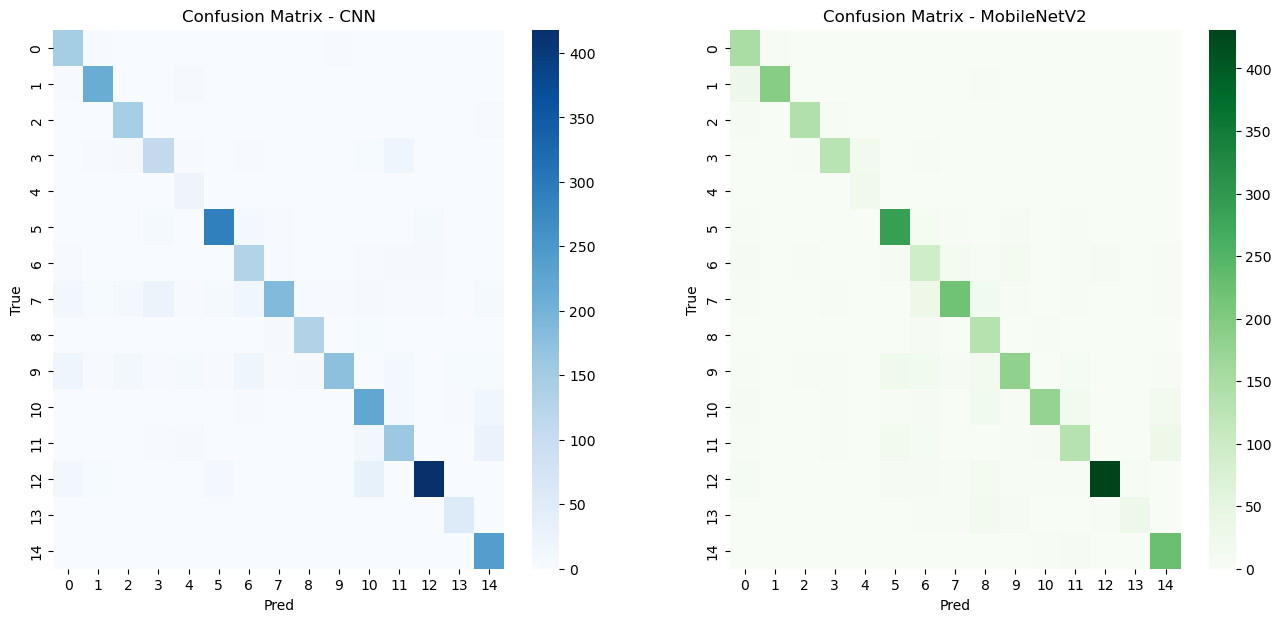

In [21]:
# Cell 12: Plot Confusion Matrix for each model
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(16,7))

sns.heatmap(cm_cnn, annot=False, fmt='d', ax=ax[0], cmap="Blues")
ax[0].set_title("Confusion Matrix - CNN")
ax[0].set_ylabel("True")
ax[0].set_xlabel("Pred")

sns.heatmap(cm_mn, annot=False, fmt='d', ax=ax[1], cmap="Greens")
ax[1].set_title("Confusion Matrix - MobileNetV2")
ax[1].set_ylabel("True")
ax[1].set_xlabel("Pred")

plt.show()


In [24]:
# Cell 13: Save models and label map
import json
with open(WORK_DIR / "label_map.json", "w") as f:
    json.dump(inv_class_indices, f)

# cnn_model.save(WORK_DIR / "cnn_model.h5")
# mobilenet_model.save(WORK_DIR / "mobilenetv2_model.h5")
# mobilenet_model.save(WORK_DIR / "mobilenet_savedmodel", save_format="tf")
# cnn_model.save(WORK_DIR / "cnn_savedmodel", save_format="tf")

print("Models & label map saved to:", WORK_DIR)
print("CNN Metrics (Acc, Prec, Rec, F1):", metrics_cnn)
print("MobileNetV2 Metrics (Acc, Prec, Rec, F1):", metrics_mn)


Models & label map saved to: E:\Nibm\Degree\4th_Year\CV\Individual_CW\CV_CW\CV_CW
CNN Metrics (Acc, Prec, Rec, F1): (0.85075587005468, 0.8668574187504898, 0.85075587005468, 0.8500934200414016)
MobileNetV2 Metrics (Acc, Prec, Rec, F1): (0.8176262463814732, 0.8368421830637375, 0.8176262463814732, 0.8192111396998796)


In [26]:
# Cell 14: Single Image Prediction (for app deployment)
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, target_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    probs = model.predict(arr)[0]
    top_idx = np.argmax(probs)
    return inv_class_indices[top_idx], float(probs[top_idx]), probs

# Example usage:
test_img = list(test_dir.rglob("*.jpg"))[0]
label, confidence, all_probs = predict_image(mobilenet_model, test_img)
print("Predicted:", label, "Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: Pepper__bell___Bacterial_spot Confidence: 0.9248100519180298
